# Community Feedings Attendance Analysis & Forecasting

## Project Overview

This project analyzes three years of weekly community meal events for a local feeding program.  
The dataset includes information about:

- **Date** of each feeding event  
- **Season** and **temperature**  
- **Food served** and associated allergens  
- **Expected turnout** (planning forecast)  
- **Actual turnout** (observed attendance)  
- **Holiday flags** (including major events such as Thanksgiving and Christmas)

The goal is to understand how factors such as season, weather, and holidays affect turnout, and to evaluate how well the planning forecasts match actual attendance over time.

## Business Questions

1. How does actual turnout compare to expected turnout over time?
2. Are there clear seasonal patterns that affect turnout?
3. Does temperature or weather meaningfully influence attendance?
4. How do certain holidays shift demand?
5. What is the year-to-year growth?
6. Can we build a simple model to predict turnout using the available features?

## Dataset

The dataset is a curated, realistic simulation of the community feeding program, designed to:

- Show **gradual growth** in turnout over multiple years.
- Include **forecasting errors** where expected turnout is sometimes too low and sometimes too high.
- Reflect **seasonal trends** and **strong holiday spikes** for Thanksgiving and Christmas.
- Incorporate **temperature**, **season**, and **food served** to support analysis and storytelling.


## Step 1 — Import Libraries
We begin by importing **pandas** for data manipulation and **matplotlib** for visualizations.  
The seaborn style gives thecharts nice, clean, and readable formatting.

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

## Step 2 — Load the Dataset
We load the cleaned dataset into a pandas **DataFrame** and preview the first few rows.  
This helps confirm the file loaded correctly and the columns appear as expected.

In [4]:
df = pd.read_csv("feedings_csv.csv")
df.head()

,date,food,allergens,expected_turnout,actual_turnout,city,holiday,season,temp,alternative
0,2/9/2023,Spaghetti & Meatballs,red meat,250,337,Charlotte,NaN,Winter,34,NaN
1,2/16/2023,Baked Chicken & Rice,NaN,258,309,Charlotte,Valentines Day,Winter,45,NaN
2,2/23/2023,Cookout,red meat,261,325,Charlotte,NaN,Winter,37,NaN
3,3/2/2023,Pizza,dairy,264,304,Charlotte,NaN,Winter,40,NaN
4,3/9/2023,Soul Food,NaN,267,325,Charlotte,NaN,Winter,40,NaN


## Step 3 — Convert Date Column & Create Time Features
In order to run time-based analysis, the date column must be converted to a true datetime object.  
We also extract additional features such as **year**, **month**, and **day** to enable seasonality and trend exploration.

In [25]:
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values('date')

df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month_name().str[:3]
df['day'] = df['date'].dt.day

df.head()

,date,food,allergens,expected_turnout,actual_turnout,city,holiday,season,temp,alternative,year,month,day,is_major_holiday,major_holiday,diff_actual_expected
0,2023-02-09,Spaghetti & Meatballs,red meat,250,337,Charlotte,NaN,Winter,34,NaN,2023,Feb,9,False,False,87
1,2023-02-16,Baked Chicken & Rice,NaN,258,309,Charlotte,Valentines Day,Winter,45,NaN,2023,Feb,16,False,False,51
2,2023-02-23,Cookout,red meat,261,325,Charlotte,NaN,Winter,37,NaN,2023,Feb,23,False,False,64
3,2023-03-02,Pizza,dairy,264,304,Charlotte,NaN,Winter,40,NaN,2023,Mar,2,False,False,40
4,2023-03-09,Soul Food,NaN,267,325,Charlotte,NaN,Winter,40,NaN,2023,Mar,9,False,False,58


# Exploratory Data Analysis (EDA)

Before modeling anything, let's take time to understand the data.  
This section looks at big-picture trends like turnout over time, seasonality, temperature effects, holiday spikes, and general growth patterns.

## Expected vs Actual Turnout Over Time

This chart compares how many people were *expected* to come each week versus how many actually did.  
It’s a quick way to spot whether forecasting improved over time, and whether there were any consistent patterns in over- or under-estimating turnout.

A few things to expect:
- In the early dates, the actual turnout often exceeded the forecast.
- In the middle, the expected forecast overshoots a bit.
- Toward the end, the two lines get closer together as estimates begin to improve.
- Major holidays like Thanksgiving and Christmas stand out clearly with higher turnout.

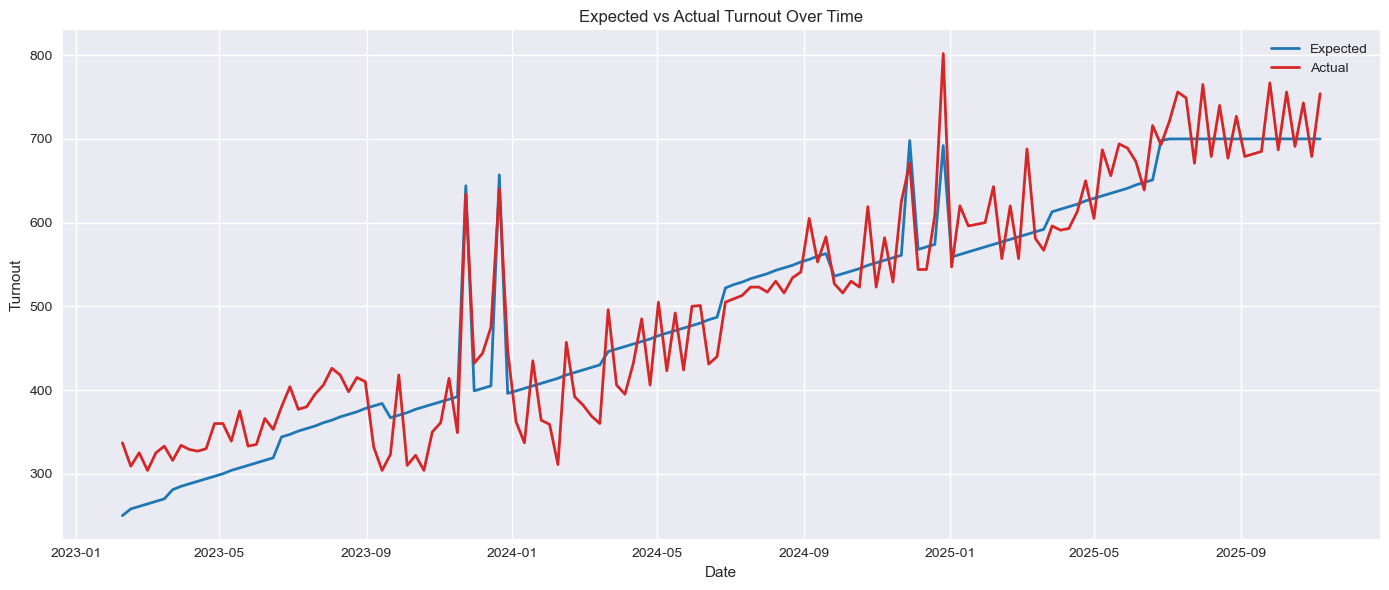

In [30]:
plt.figure(figsize=(14,6))

plt.plot(df['date'], df['expected_turnout'], 
         label='Expected', linewidth=2, color='tab:blue')

plt.plot(df['date'], df['actual_turnout'], 
         label='Actual', linewidth=2, color='tab:red')

plt.title("Expected vs Actual Turnout Over Time")
plt.xlabel("Date")
plt.ylabel("Turnout")
plt.legend()
plt.tight_layout()
plt.show()

## Seasonal Patterns

Here we take a look at the **average** turnout for each season.  
The is to see whether certain seasons naturally bring more people. Whether that’s due to weather, school/work schedules, or just general patterns in the community.

Typically, Summer and Fall tend to be stronger, while Winter can vary.

In [31]:
season_summary = df.groupby('season')[['expected_turnout','actual_turnout']].mean().round(1)
season_summary

,expected_turnout,actual_turnout
season,,
Fall,530.8,532.0
Spring,466.2,479.9
Summer,535.6,544.1
Winter,461.9,472.6


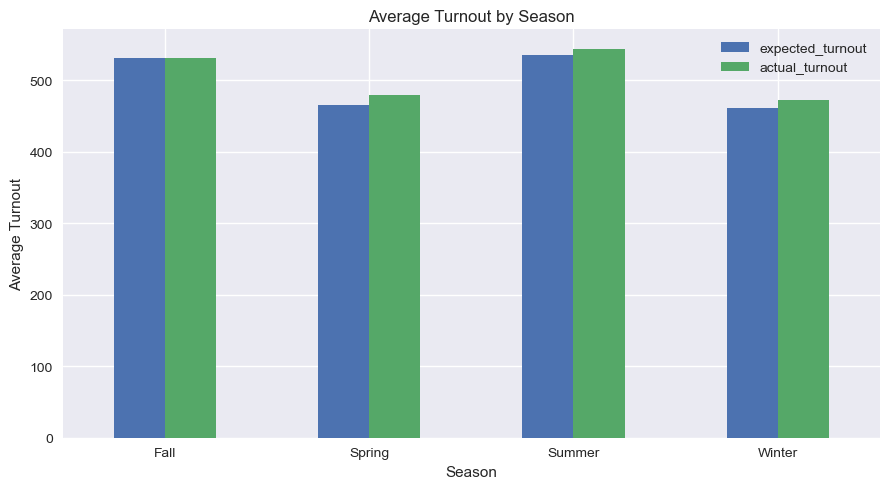

In [32]:
season_summary.plot(kind='bar', figsize=(9,5))
plt.title("Average Turnout by Season")
plt.xlabel("Season")
plt.ylabel("Average Turnout")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Temperature vs Turnout

This scatterplot helps check whether temperature plays any role in attendance.  
As we can see, the relationship isn't perfectly linear, but clustering patterns give a sense of how weather can impact turnout. Extreme temperatures such as very cold or very hot days may pull attendance slightly down or even create more variability.

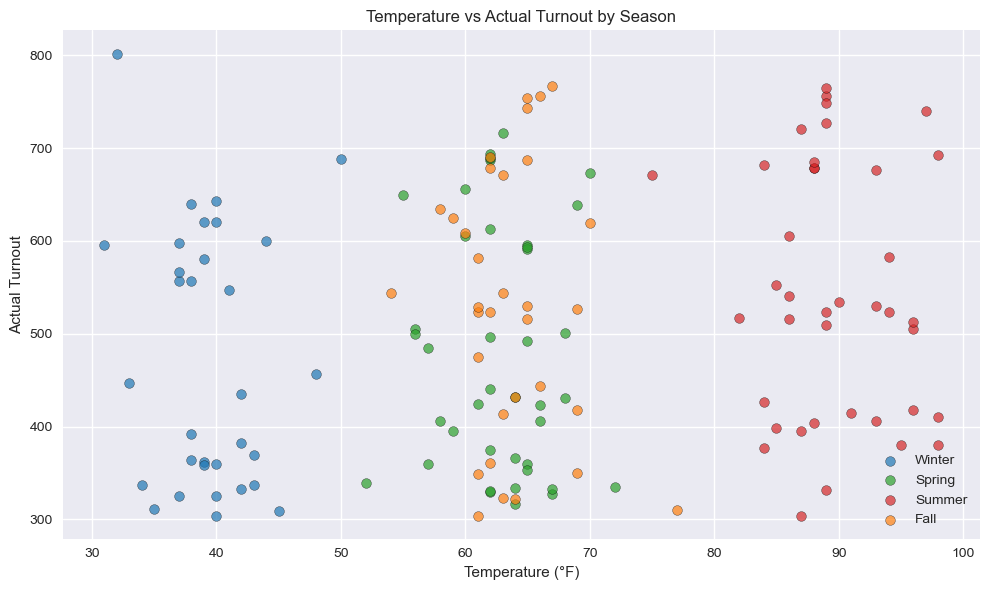

In [36]:
plt.figure(figsize=(10,6))

colors = {
    'Winter': 'tab:blue',
    'Spring': 'tab:green',
    'Summer': 'tab:red',
    'Fall': 'tab:orange'
}

for season in df['season'].unique():
    subset = df[df['season'] == season]
    plt.scatter(
        subset['temp'],
        subset['actual_turnout'],
        color=colors[season],
        label=season,
        edgecolor='black',
        linewidth=0.3,
        alpha=0.7
    )

plt.title("Temperature vs Actual Turnout by Season")
plt.xlabel("Temperature (°F)")
plt.ylabel("Actual Turnout")
plt.legend()
plt.tight_layout()
plt.show()

## Holiday Impact

Not *all* holidays behave the same.  
Regular holidays (Valentine’s Day, Labor Day, etc.) don’t show any major attendance changes.  
However, Thanksgiving and Christmas reliably draw much higher turnout, so they’re flagged and compared in the following section.

In [37]:
major = ["Thanksgiving Day", "Christmas Day"]
df["is_major_holiday"] = df["holiday"].isin(major)

holiday_summary = df.groupby("is_major_holiday")[["expected_turnout","actual_turnout"]].mean().round(1)
holiday_summary

,expected_turnout,actual_turnout
is_major_holiday,,
False,493.8,502.5
True,672.8,686.8


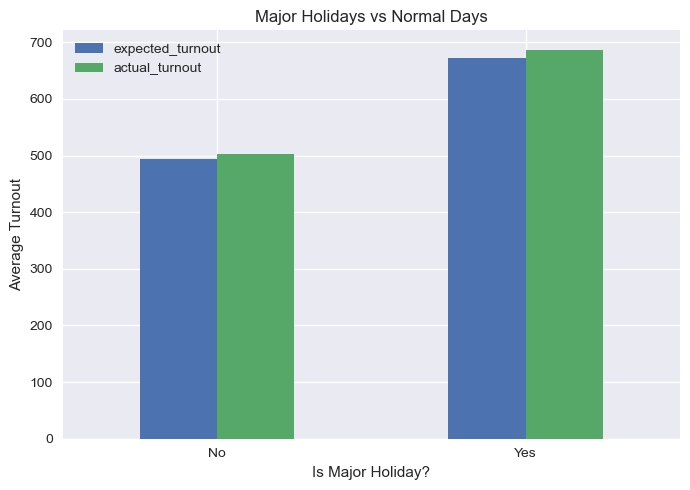

In [38]:
holiday_summary.plot(kind='bar', figsize=(7,5))
plt.title("Major Holidays vs Normal Days")
plt.xlabel("Is Major Holiday?")
plt.ylabel("Average Turnout")
plt.xticks([0,1], ["No","Yes"], rotation=0)
plt.tight_layout()
plt.show()

## Year-Over-Year Growth

This section looks at how turnout has changed over the three years.  
It’s a simple way to see whether the program is growing, staying steady, or fluctuating. 
We also calculate percent change to get a clearer picture of just how much things have shifted from year to year.

In [39]:
year_summary = df.groupby('year')[['expected_turnout','actual_turnout']].mean().round(1)
year_summary

,expected_turnout,actual_turnout
year,,
2023,351.7,375.7
2024,503.5,491.5
2025,647.1,663.9


In [40]:
year_summary.pct_change().round(3) * 100

,expected_turnout,actual_turnout
year,,
2023,NaN,NaN
2024,43.2,30.8
2025,28.5,35.1


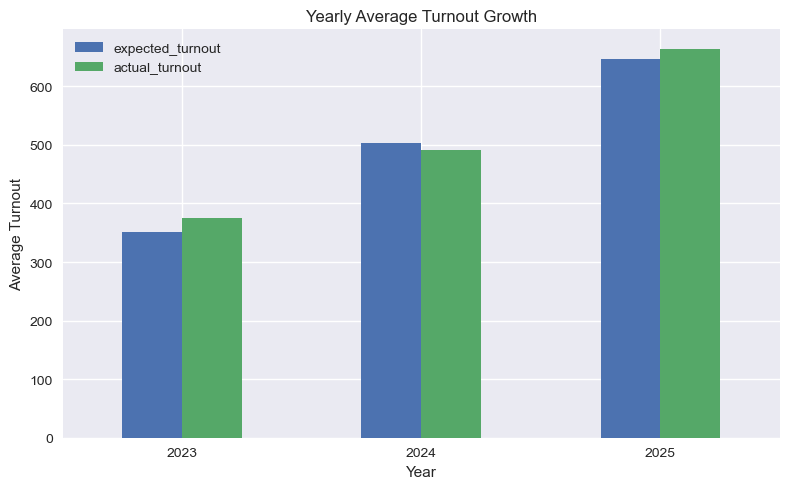

In [41]:
year_summary.plot(kind='bar', figsize=(8,5))
plt.title("Yearly Average Turnout Growth")
plt.xlabel("Year")
plt.ylabel("Average Turnout")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Outlier Detection

Here we identify the events where actual turnout was much *higher* or *lower* than expected.  
These “surprise” days matter because they show where forecasting missed the mark, either because of an unexpected surge in need or a day where turnout was lower than originally anticipated.

In [42]:
df['diff'] = df['actual_turnout'] - df['expected_turnout']
df['abs_diff'] = df['diff'].abs()

outliers = df[df['abs_diff'] > 80]
outliers[['date','holiday','season','expected_turnout','actual_turnout','diff']]

,date,holiday,season,expected_turnout,actual_turnout,diff
0,2023-02-09,NaN,Winter,250,337,87
52,2024-02-08,NaN,Winter,414,311,-103
98,2024-12-26,Christmas Day,Winter,692,802,110
108,2025-03-06,NaN,Winter,586,688,102


# Phase 2 — Predicting Turnout

In this section, we build a simple model to estimate actual turnout based on:
- expected turnout  
- temperature  
- whether the day is a major holiday  
- and the season

We use this to get a sense of which factors matter most and how well a basic model can support future planning.

## Preparing Features for Modeling

We create a few new columns to make the data usable for the model:
- `A holiday flag` (Thanksgiving/Christmas)
- `One-hot encoded season columns`  
These help the model interpret categorical information like holidays and seasons.

In [43]:
major = ["Thanksgiving Day", "Christmas Day"]
df["is_major_holiday"] = df["holiday"].isin(major).astype(int)

season_dummies = pd.get_dummies(df['season'], prefix='season')

model_df = pd.concat([df, season_dummies], axis=1)

model_df.head()

,date,food,allergens,expected_turnout,actual_turnout,city,holiday,season,temp,alternative,...,day,is_major_holiday,major_holiday,diff_actual_expected,diff,abs_diff,season_Fall,season_Spring,season_Summer,season_Winter
0,2023-02-09,Spaghetti & Meatballs,red meat,250,337,Charlotte,NaN,Winter,34,NaN,...,9,0,False,87,87,87,False,False,False,True
1,2023-02-16,Baked Chicken & Rice,NaN,258,309,Charlotte,Valentines Day,Winter,45,NaN,...,16,0,False,51,51,51,False,False,False,True
2,2023-02-23,Cookout,red meat,261,325,Charlotte,NaN,Winter,37,NaN,...,23,0,False,64,64,64,False,False,False,True
3,2023-03-02,Pizza,dairy,264,304,Charlotte,NaN,Winter,40,NaN,...,2,0,False,40,40,40,False,False,False,True
4,2023-03-09,Soul Food,NaN,267,325,Charlotte,NaN,Winter,40,NaN,...,9,0,False,58,58,58,False,False,False,True


## Selecting the Features and Target

Our target is `actual_turnout`. This represents the true number of attendees, and the number we want to predict.

Our **features** include:
- `expected_turnout`: the forecast or planned turnout, a strong baseline predictor.
- `temp`: the temperature on the day of the event.
- `is_major_holiday`: whether the day is Thanksgiving or Christmas.
- One-hot encoded seasonal indicators (`season_Fall`, `season_Spring`, `season_Summer`, `season_Winter`).

These variables give the model a mix of operational forecasts, environmental conditions, and context.

In [44]:
y = model_df["actual_turnout"]

feature_cols = [
    "expected_turnout",
    "temp",
    "is_major_holiday",
    "season_Fall",
    "season_Spring",
    "season_Summer",
    "season_Winter"
]

X = model_df[feature_cols]

X.head(), y.head()

(   expected_turnout  temp  is_major_holiday  season_Fall  season_Spring  \
 0               250    34                 0        False          False   
 1               258    45                 0        False          False   
 2               261    37                 0        False          False   
 3               264    40                 0        False          False   
 4               267    40                 0        False          False   
 
    season_Summer  season_Winter  
 0          False           True  
 1          False           True  
 2          False           True  
 3          False           True  
 4          False           True  ,
 0    337
 1    309
 2    325
 3    304
 4    325
 Name: actual_turnout, dtype: int64)

## Train/Test Split

To evaluate the model fairly, we split the data into:

- **Training set (80%)**: used to fit the model.
- **Test set (20%)**: used to evaluate how well the model generalizes to unseen data.

This prevents us from overfitting to the full dataset and gives a more realistic estimate of predictive performance. In additon, the training set teaches the model; the test set checks whether the model generalizes to dates it hasn't seen before.

In [45]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,       # 20% test, 80% train
    random_state=42      # makes results reproducible
)

X_train.shape, X_test.shape

((115, 7), (29, 7))

## Fit a Linear Regression Model

We use a simple **linear regression** model to predict actual turnout.  
The model learns a weighted combination of our features (expected turnout, temperature, season, and holiday indicator) that best approximates the observed turnout values in the training set to it finds the best-fitting line that connects our features to the actual turnout.

In [46]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

## Model Evaluation

We evaluate the model on the test set using:

- **Mean Absolute Error (MAE)**: average size of the prediction error in absolute terms. In our case, the average error in number of people.
- **Root Mean Squared Error (RMSE)**: similar to MAE but penalizes large errors more heavily.
- **R-squared (R²)**: how much of the variation in actual turnout can the model explain?

These metrics judge how accurately the model predicts turnout and whether the chosen features capture meaningful patterns in the data.

In [48]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

mae, rmse, r2

(40.088478201045056, np.float64(44.53039031618338), 0.8875306124740949)

## Interpreting Model Coefficients

We examine the learned coefficients to understand how each feature influences predicted turnout.

- **Positive** coefficients indicate features that are associated with **higher** turnout.
- **Negative** coefficients indicate features associated with **lower** turnout (all else held constant).

This helps translate the model into real, actionable insights instead of treating it like a black box.

In [49]:
coef_df = pd.DataFrame({
    "feature": feature_cols,
    "coefficient": model.coef_
}).sort_values("coefficient", ascending=False)

coef_df

,feature,coefficient
2,is_major_holiday,51.581208
6,season_Winter,32.199751
4,season_Spring,1.981058
1,temp,1.015208
0,expected_turnout,0.988724
3,season_Fall,-7.465241
5,season_Summer,-26.715567


# How to Use This Model Operationally

This predictive model is designed to help improve planning and resource allocation for future community feeding events. Here are several ways it can be applied in day-to-day operations:

---

## 1. Improve Forecast Accuracy

The model provides a more accurate turnout prediction than manual estimates alone.  
Planers and organizers can use the model’s predicted turnout instead of relying solely on experience or intuition when determining expected attendance for upcoming events.

This helps ensure:
- fewer shortages on high-turnout days,
- reduced waste on lower-turnout days,
- and more consistent preparedness.

---

## 2. Adjust Plans Based on Season and Weather

Since season and temperature influence turnout, staff can adjust preparation based on upcoming conditions.

Examples:
- Expecting warmer weather? Slightly increase food quantity.
- Winter week with cold temperatures? Expect turnout to be *modestly* lower.

These adjustments help better align resources with real-world turnout drivers.

---

## 3. Plan for Major Holidays

Because the model identifies large spikes for Thanksgiving and Christmas, these dates should have separate planning guidelines.

Operational actions include:
- Ordering significantly more food.
- Scheduling additional volunteers.
- Preparing larger seating and serving areas.

The model quantifies these spikes so that planning can be proactive as opposed to reactive.

---

## 4. Identify High-Risk Forecast Errors

Comparing model predictions to expected turnout helps flag weeks where planning may be inaccurate.

For example:
- If expected turnout is much lower than the model’s prediction → at risk of under-preparation.
- If expected turnout is much higher → at risk of over-preparation.

This creates an early warning system for correcting forecasts before the event.

---

## 5. Communicate Data-Driven Insights to Stakeholders

The model provides a clean, numerical way to explain expected turnout to:
- program directors,
- volunteers,
- donors,
- partners,
- and grant writers.

Having a quantitative forecast helps justify resource requests and demonstrate responsible planning.

---

## 6. Establish a Feedback Loop

Each new event provides:
- actual turnout,
- temperature,
- updated seasonal patterns,
- and holiday outcomes.

These can be added to the dataset to retrain the model, improving accuracy over time.

The more data accumulated, the better the forecasting system becomes.

# Key Findings & Insights

## 1. Forecast vs Actual Turnout Over Time

- Early in the timeline, **actual turnout consistently exceeds expected turnout**, suggesting initial under-forecasting and/or rapid program growth.
- However, in the middle period, we see the pattern reverses: **expected turnout is temporarily higher than actual turnout**, indicating probable over-correction in planning.
- In the later portion of the timeline, expected and actual turnout **converge and track more closely**, suggesting that the forecasting process has improved over time.
- Overall, turnout shows a **clear upward trend** over the analysis period, consistent with a growing community program.

## 2. Seasonal Patterns

- Average turnout is **higher in Summer and Fall** compared to Winter, consistent with better weather and possibly increased mobility in the community.
- Winter events show more moderate turnout, reflecting potential weather constraints and holiday schedule disruptions.
- The seasonal analysis confirms that **seasonality matters** and should be accounted for when planning.

## 3. Temperature Effects

- The temperature vs turnout scatterplot shows **clusters by each season**, with warmer temperatures associated with late Spring and Summer events.
- While this relationship is not perfectly linear, extreme temperatures (very cold or very hot) can be associated with more variability in turnout.
- This suggests that **temperature is a useful contextual factor**, especially when planning for outdoor or weather-sensitive events.

## 4. Holiday Impact

- **Thanksgiving and Christmas** show clear spikes in both expected and actual turnout, significantly above normal days.
- Other holidays (e.g., Valentine’s Day, Labor Day) do not show the same magnitude of change and behave more like regular weekly events.
- This confirms that major holidays require **additional planning, capacity, and resources**.

## 5. Year-over-Year Growth

- Annual averages indicate **steady growth in both expected and actual turnout** across the three-year period.
- The growth in actual turnout suggests that the program is serving more people over time, potentially due to increased community need or awareness.
- This trend supports the narrative that the program is **expanding and becoming more impactful**.

## 6. Predictive Model Performance

- A simple linear regression model using:
  - `expected_turnout`,  
  - `temp`,  
  - seasonal indicators, and  
  - a major-holiday flag  
  demonstrates that expected turnout is a strong primary predictor of actual turnout.
- Temperature and season add **incremental explanatory power**, and the major-holiday indicator captures the strongest spikes.
- The model achieves reasonable performance on the test set (as measured by MAE, RMSE, and R²), showing that even a simple model can support **data-informed forecasting**.

# Business Recommendations

Based on the analysis, we can offer several practical recommendations:

1. **Refine Forecasting Using Historical Data**
   - Incorporate historical variables (actual turnout, season, and temperature, etc.) into the forecasting process rather than relying on static estimates.
   - Use the regression model as a decision-support tool when setting future expected turnout values.

2. **Plan Extra Capacity for Major Holidays**
   - Thanksgiving and Christmas consistently show a **much higher turnout** than normal days.
   - For these dates, plan additional food, volunteers, and seating to ensure guests are fully accommodated.

3. **Adjust for Seasonal and Weather Trends**
   - Summer and Fall events tend to draw higher turnout; as a result one can:
     - Schedule additional events or outreach during these seasons.
     - Consider weather-appropriate menu planning (e.g., cooler foods in hot months, warm meals in colder months).
   - In Winter, monitor extreme weather conditions closely when planning resources and communication.

4. **Monitor Forecast Accuracy Over Time**
   - Track the difference between expected and actual turnout for each event.
   - This feedback loop can be used to continuously adjust the forecasting model and reduce over or under-preparation.

5. **Use Insights in Grant Reporting and Stakeholder Communication**
   - Highlight the year-over-year growth in turnout and the effectiveness of improved planning.
   - Use charts and metrics from this analysis to demonstrate **impact**, **demand**, and **operational learning** to funders and partners.

# Model Limitations & Next Steps

Even though the current model performs well and provides meaningful insights, it has several limitations that should be considered when interpreting predictions. These limitations also highlight opportunities for future improvements.

---

## 1. Linear Assumptions

The model assumes relationships are linear—for example, that every degree of temperature has the same effect.  
In reality, turnout patterns may level off, spike, or behave differently in extreme conditions.

A non-linear model (like Random Forests) could capture more complex relationships.

---

## 2. Limited Feature Set

The model only uses:
- expected turnout,
- temperature,
- season,
- and major holidays.

However, other important factors can influence turnout, such as:
- precipitation,
- day of week,
- local events,
- economic conditions,
- transportation availability,
- or school schedules.

Incorporating more variables could increase predictive accuracy.

---

## 3. Interaction Effects Not Explicitly Modeled

Although regression captures some implied interactions (due to correlated variables), it does not explicitly model combinations like:
- “holiday + winter,”
- “high temp + summer,”
- “cold + rain.”

Adding interaction terms or switching to a tree-based model could reveal more nuanced turnout drivers.

---

## 4. Limited Time-Series Awareness

The model does not explicitly understand “time”—it learns trends indirectly through other variables.  
For long-term forecasting, a time-series model (ARIMA, Prophet, or LSTM) would better capture seasonality, trend, and momentum.

---

## 5. Potential Data Bias

If early years in the dataset have lower turnout and later years have higher turnout, the model might underpredict or overpredict depending on how the data is distributed.

Retraining the model regularly helps mitigate this issue.

---

# Next Steps for Model Improvement

## 1. Add More Features
Incorporate factors like:
- rainfall,
- wind chill,
- special events,
- volunteer count,
- menu type,
- temperature feels-like.

These can strengthen the model.

---

## 2. Build a Non-Linear Model
After the linear regression baseline, consider:
- Random Forest Regressor  
- Gradient Boosting Regressor  
- XGBoost  
These handle interactions and non-linear relationships more naturally.

---

## 3. Explore Time-Series Forecasting
Use time-series models to forecast turnout weeks or months ahead.

These models can better handle:
- long-term trends,
- seasonality,
- repeating yearly patterns,
- and holiday effects.

---

## 4. Design a Forecasting Dashboard
Create a simple UI or a dashboard (Tableau, Power BI, or Streamlit) where staff can:
- enter expected turnout,
- enter predicted temp,
- select season,
- mark holiday,
- receive a prediction instantly.

This makes the model usable by non-technical stakeholders.

---

## 5. Continuous Improvement
Retrain the model regularly as more data is collected.  
This gradually improves accuracy and adapts to changes in community needs.